<a href="https://colab.research.google.com/github/kkb-mmmut/Intestinal_Disease/blob/main/Major.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Intestinal AI Model to Detect Disease***

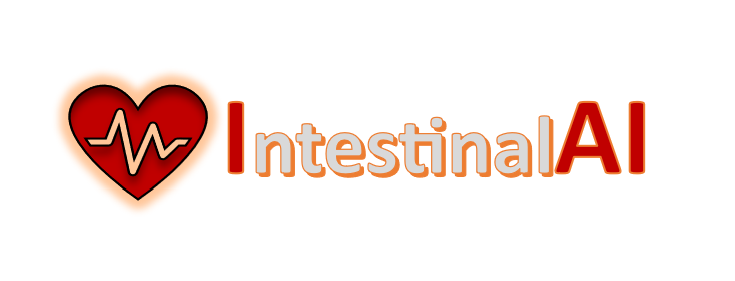

**Required libraries are Importing**

In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# to split the data into random training and testing subsets.
from sklearn.model_selection import train_test_split

# to calculate the confusion matrix
from sklearn.metrics import confusion_matrix

# to reduce the learning rate when a metric has stopped improving.
from keras.callbacks import ReduceLROnPlateau

# to be able to import use the pre-train VGG19 model
from tensorflow.keras.applications import VGG19

# to convert class vector (y) (integers) to binary class matrix.
from tensorflow.keras.utils import to_categorical

# to generate altered images
from keras.preprocessing.image import ImageDataGenerator

# to initialize the desente gradient method
from tensorflow.keras.optimizers import SGD, Adam

from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

**Mound Google Drive for the saved trained dataset.**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Request to delete seved model or not**

In [11]:
if os.path.isdir("./saved_model"):
    try:
        strr= input('delete saved model? Y/N')
        if strr == 'Y' or strr == 'y':
            # !rm -rf "./saved_model"
            print("Sorry, You can not delete this model, It's took a long time to trained this one about two days.")
        else:
            print('the old model will be used')
    except:
        
        pass



**Configure the dataset**

 Download the dataset 


In [12]:
"""
    The functions used to retrieve the dataset
"""

# ------------------------------------------------- ---------------------
def in_colab():
    """
        detect if notebook is running on colab

    Returns:
        boolean: true or false
    """
    try:
        import google.colab

        IN_COLAB = True
    except:
        IN_COLAB = False
    return IN_COLAB


# ------------------------------------------------- ----------------------
def in_kaggle():
    """
        detect if notebook is running on Kaggle

    Returns:
        boolean: true or false
    """
    import os

    return os.path.isdir("../input") and os.path.isdir("/kaggle/working")


# ------------------------------------------------- ------------------------
def download_dataset(url, dataset_name):
    """
        download the dataset dfrom a given link

    args:
        URL (str): the link to download the dataset
        dataset_name (str): the name of the dataset (kvasir-dataset)

    Returns:
        str: the path to the dataset download
    """ """"""
    import tensorflow as tf
    import os

    path_to_zip = tf.keras.utils.get_file(
        f"{dataset_name}.zip", origin=URL, extract=True
    )
    path = os.path.join(os.path.dirname(path_to_zip), dataset_name)
    return path

In [13]:
# if we are on colab
if in_colab():
    # if the dataset does not exist
    if not os.path.isdir("/root/.keras/datasets/kvasir-dataset"):
        URL=f"https://datasets.simula.no/downloads/kvasir/kvasir-dataset.zip"
        dataset_dir = download_dataset(URL, "kvasir-dataset")

elif in_kaggle():
    dataset_dir = "../input/kvasir-dataset/kvasir-dataset"

else:
    dataset_dir = "./kvasir-dataset"

print(f"the dataset is available: {dataset_dir}")

the dataset is available: /root/.keras/datasets/kvasir-dataset


**Define dataset categories**

In [14]:
def get_dataCategories(dataset_dir):
    """
        get the categories (class) of the dataset from the path of the dataset
        in question.

    args:
        dataset_dir (str): dataset path

    Returns:
        list: list of categories
        list: list of number of files by categories
    """
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories. sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])




categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"category": categories, "number of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  8


,category,number of files
0,dyed-lifted-polyps,500
1,dyed-resection-margins,500
2,esophagitis,500
3,normal-cecum,500
4,normal-pylorus,500
5,normal-z-line,500
6,polyps,500
7,ulcerative-colitis,500


**Create all the features X as well s the labels y**

In [15]:
def create_dataset(datadir, categories, img_wid, img_high):
    """
        reads the images from the dataset and resizes them using the dimensions
        (img_wid x img_high ) to create all X features and y labels

    args:
        datadir (str): dataset path
        categories (str): the different classes of the dataset
        img_wid(int): custom width
        img_high(int): custom height

    Returns:
        X(numpy): the set of features (i.e: includes all the images read)
        y(numpy): the set of labels (i.e: includes the categories of each image of X)
    """

    x, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories. index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                x.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                pass

    y = np.array(y)
    X = np.array(x).reshape(y.shape[0], img_wid, img_wid, 3)
    return X,y




img_wid, img_high = 100, 100
x, y = create_dataset(dataset_dir, categories, img_wid, img_high)

print(f"X: {x.shape}")
print(f"y: {y.shape}")

X: (4000, 100, 100, 3)
y: (4000,)


**Display a random images for each category**

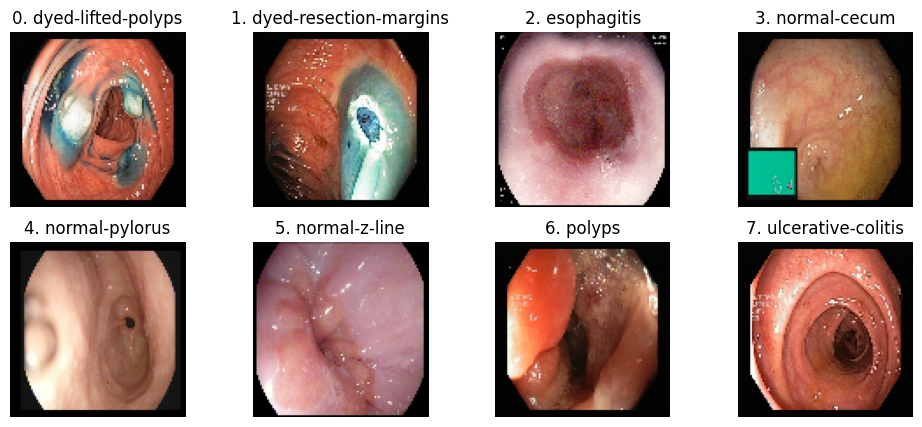

In [16]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    # plt.imshow(X[idx][:,:,::-1])
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()



**Model creation and learning**

Create the training,testing and validation set


In [17]:
# en convertie y en format scaler
Y = np.reshape(y, (len(y), 1))

# split dataset to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    x, Y, train_size=0.8, random_state=42
)
print(f"X_train: {X_train.shape}")
print(f"t_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3200, 100, 100, 3)
t_train: (3200, 1)
X_test: (800, 100, 100, 3)
y_test: (800, 1)


In [18]:
# defining training and test sets
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)
x_test = X_test

# Dimension of the dataset
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 1)
x_train:(960, 100, 100, 3),  y_train:(960, 1)
x_train:(800, 100, 100, 3),  y_train:(800, 1)


**OneHot Encoding**

In [19]:
# One Hot Encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Verifying the dimension after one hot encoding
print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_train:{x_val.shape},  y_train:{y_val.shape}")
print(f"x_train:{x_test.shape},  y_train:{y_test.shape}")

x_train:(2240, 100, 100, 3),  y_train:(2240, 8)
x_train:(960, 100, 100, 3),  y_train:(960, 8)
x_train:(800, 100, 100, 3),  y_train:(800, 8)


**Image generation**

In [20]:
# Image Data Augmentation
train_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

val_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

test_generator = ImageDataGenerator(
    rotation_range=2, horizontal_flip=True, zoom_range=0.1
)

# Fitting the augmentation defined above to the data
train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**Download the pre-trained model VGG19**

In [21]:
# if it has already been created and saved --> read the model
if os.path.isfile("./saved_model/vgg19_model.h5"):
    #loadmodel
    base_model = load_model("./saved_model/vgg19_model.h5")

# if it has not already been created --> create the model and save it
else:
    base_model = VGG19(
        include_top=False,
        weights="imagenet",
        input_shape=(100, 100, 3),
        classes=y_train.shape[1],
    )
    # save model
    base_model.save("./saved_model/vgg19_model.h5")

80134624/80134624 [==============================] - 1s 0us/step


In [22]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

In [23]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
Total params: 20,024,384
Trainable params: 20,024,384
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.add(Dense(1024, activation=("relu"), input_dim=512))
model.add(Dense(512, activation=("relu")))
model.add(Dense(256, activation=("relu")))
model.add(Dropout(0.3))
model.add(Dense(128, activation=("relu")))
# model.add(Dropout(.2))
model.add(Dense(y_train.shape[1], activation=("softmax")))

**Hyperparametering**

In [26]:

batch_size = 100

epochs = 50

learn_rate = 0.001

sgd = SGD(learning_rate=learn_rate, momentum=0.9, nesterov=False)

model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
lrr = ReduceLROnPlateau(monitor="val_acc", factor=0.01, patience=3, min_lr=1e-5)

# **Model training**

In [28]:
# if model has already been trained and saved ---> read model
if os.path.isfile("/content/drive/MyDrive/Colab Notebooks/model.h5"):

    # read the model
    model = load_model("/content/drive/MyDrive/Colab Notebooks/model.h5")

    # if model history was saved --> read history
    if os.path.isfile("./saved_model/model_history.npy"):

        # read history
        history = np.load("./saved_model/model_history.npy", allow_pickle="TRUE").item()
    else:
        history = None

# if the model has not already been trained --> train the model
else:
    history = model.fit(
        # train_generator.flow(x_train, y_train, batch_size= batch_size),
        x_train,
        y_train,
        epochs=epochs,
        steps_per_epoch=x_train.shape[0] // batch_size,
        validation_data=val_generator.flow(x_val, y_val, batch_size=batch_size),
        validation_steps=250,
        callbacks=[lrr],
        verbose=1,
    )
    history = history. history

    # save model
    np.save("./saved_model/model_history.npy", history)
    model.save("./saved_model/model.h5")

In [29]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", round(score[0], 3))
print("Test accuracy:", round(score[1], 3))

Test loss: 0.33
Test accuracy: 0.95


**Model evalution**

In [30]:
"""
    The functions uses displays the confusion matrix
"""

# ------------------------------------------------- ---------------------
def cm_plt(ax, cm, classes, cmap, title, normalize):
    """
    displays the confusion matrix belongs to the axis between

    args:
        ax (plt): ax used to display the matrix
        cm (numpy): confusion matrix
        classes (list): list of classes
        cmap (plt): matrix color
        title (str): matrix title
        normalize (boolean): true displays cm normalized

    Returns:
        plt: the ax that will be displayed
    """
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return ax


# ------------------------------------------------- ---------------------
# Defining function for confusion matrix plot
def plt_confusion_mat(cm, classes, fig_size, cmap=plt.cm.Blues):
    """
        display normalized and non-normalized cm

    args:
        cm (numpy): confusion matrix
        classes (list): list of classes
        fig_size(_type_):_description_
        cmap (plt, optional): flow of the matrix. Defaults to plt.cm.Blues.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size)
    ax1 = cm_plt(
        ax1,
        cm,
        classes,
        cmap,
        title="Confusion matrix, without normalization",
        normalize=False,
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax2 = cm_plt(
        ax2,
        cmn,
        classes,
        cmap,
        title="Normalized confusion matrix",
        normalize=True,
    )

In [31]:
# Making prediction
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

25/25 [==============================] - 121s 5s/step


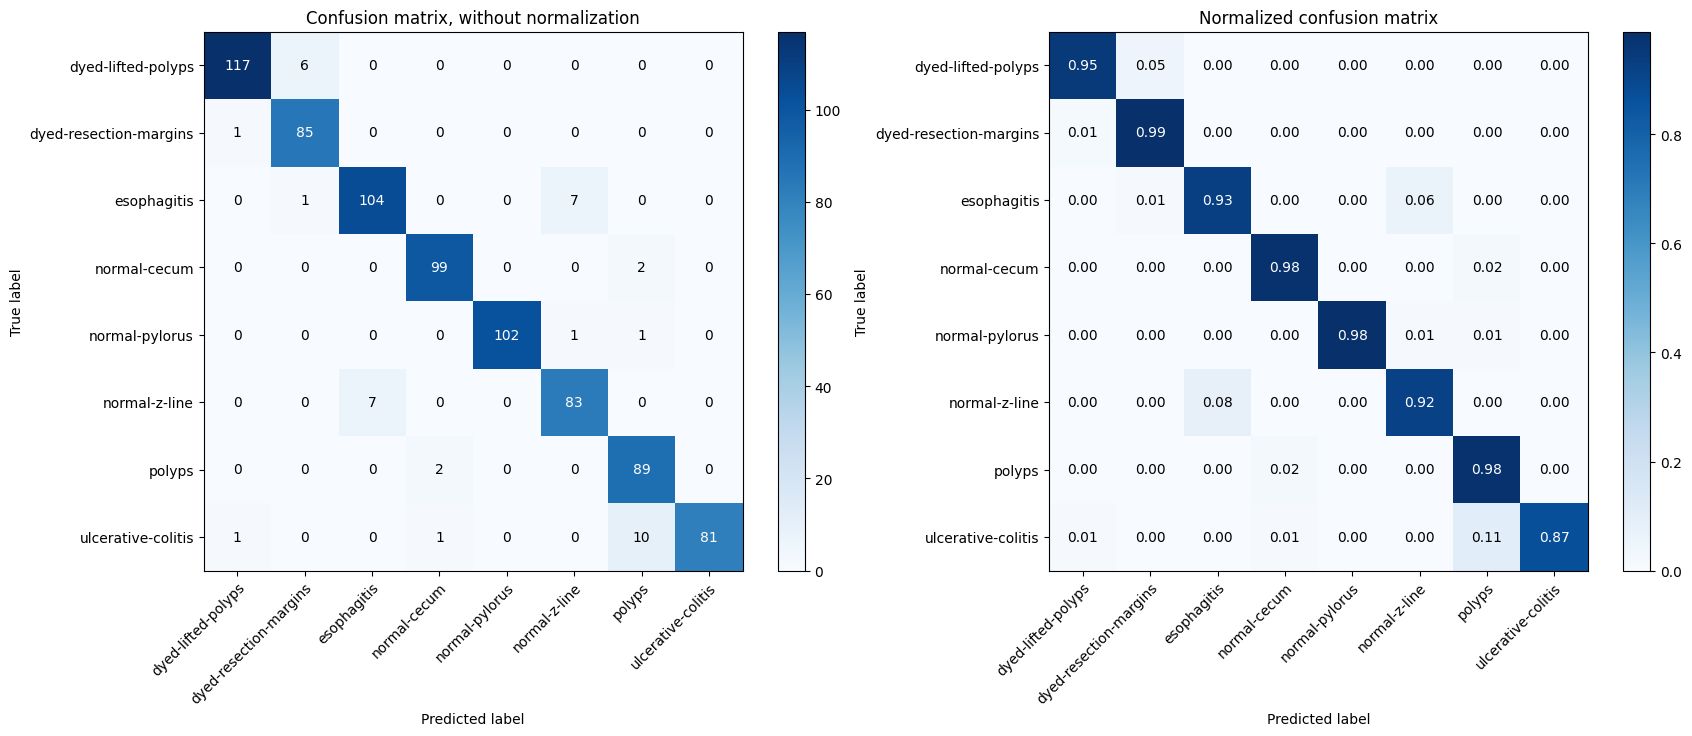

In [32]:
# get confusion matrix
confuision_mat = confusion_matrix(y_true, y_pred)
# plot confusion_mat
plt_confusion_mat(confuision_mat, classes=categories, fig_size=(20, 7))

In [33]:
from sklearn.metrics import classification_report

# assume y_true and y_pred are the ground truth and predicted labels, respectively
# and that they are in the same order
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       123
           1       0.92      0.99      0.96        86
           2       0.94      0.93      0.93       112
           3       0.97      0.98      0.98       101
           4       1.00      0.98      0.99       104
           5       0.91      0.92      0.92        90
           6       0.87      0.98      0.92        91
           7       1.00      0.87      0.93        93

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



1/1 [==============================] - 0s 166ms/step


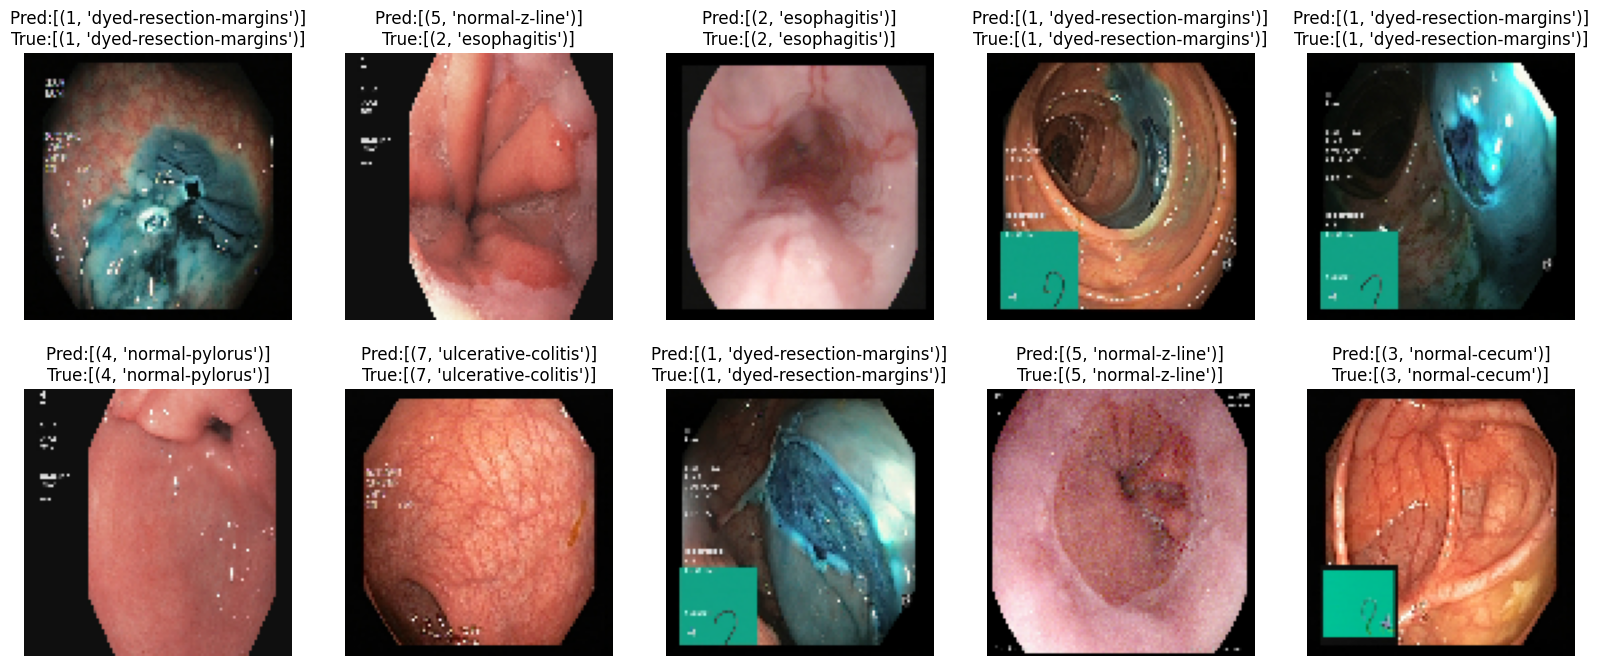

In [34]:
def predict_categorie_img(img, model, categories):
    """
        predict the class of a given image

    args:
        img (numpay): the given image
        model (_type_): the model used for the prediction
        categories (list): list of classes

    Raises:
        TypeError: error if the image is not in RGB (image_dim < 3)

    Returns:
        int: the index of the predie class
        str: the predie class
    """
    try:
        img = img[None,:,:,:]
    except:
        raise TypeError("test image dimension!= 3")
    predict = model.predict(img)
    idx_cat = np.argmax(predict, axis=1)[0]
    return idx_cat, categories[idx_cat]

plt. figure(figsize=(20, 8))
for i in range(10):
    idx = np.random.randint(len(y))
    img = x[idx]
    pred_class = predict_categorie_img(img, model, categories)
    true_class = y[idx], categories[y[idx]]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img[:,:,::-1])
    plt.title(f"Pred:[{pred_class}]\nTrue:[{true_class}]")
    plt.axis("off")
plt.show()